In [1]:
#Import Packages

from bs4 import BeautifulSoup as BS
import urllib.request
import pandas as pd

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
#Read in GeoJSONs with Geopandas

plates_gdf = gpd.read_file("MR_Data/PB2002_plates.json")
countries_gdf = gpd.read_file("MR_Data/countries.geojson")
earthquakes_gdf = gpd.read_file("MR_Data/earthquakes.GeoJSON")
volcanoes_gdf = gpd.read_file("MR_Data/volcanoes.GeoJSON")
vents_gdf = gpd.read_file("MR_Data/vents.GeoJSON")

fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.3)
earthquakes_gdf.plot(ax=ax, markersize = 25, column = "Magnitude", cmap = "rainbow", marker = "x")
volcanoes_gdf.plot(ax=ax, markersize = 25, column = "Type", cmap = "rainbow", marker = "^")
vents_gdf.plot(ax=ax, markersize = 25, column = "Depth", cmap = "rainbow", marker = "|")

earthquakes_gdf

volcanoes_gdf.head(1)

vents_gdf.head(1)

eruptions = pd.read_table("MR_Data/volerup.txt")

#eruptions
eruptions.info()

eruptions = eruptions.drop(["TOTAL_HOUSES_DESTROYED_DESCRIPTION", "TOTAL_HOUSES_DESTROYED", "TOTAL_DAMAGE_DESCRIPTION", 
                            "TOTAL_DAMAGE_MILLIONS_DOLLARS", "TOTAL_INJURIES_DESCRIPTION", "TOTAL_INJURIES", 
                            "TOTAL_MISSING_DESCRIPTION", "TOTAL_MISSING", "TOTAL_DEATHS_DESCRIPTION", 
                            "HOUSES_DESTROYED_DESCRIPTION", "HOUSES_DESTROYED", "DAMAGE_DESCRIPTION", 
                            "DAMAGE_MILLIONS_DOLLARS", "INJURIES_DESCRIPTION", "INJURIES", "MISSING_DESCRIPTION", 
                            "MISSING", "DEATHS_DESCRIPTION", "DEATHS", "Agent"], axis = 1)
#geometry_erupt = [Point(xy) for xy in zip(eruptions.Longitude, eruptions.Latitude)]
#crs = {"init": "epsg:4326"} 
#eruptions_gdf = gpd.GeoDataFrame(eruptions, crs=crs, geometry=geometry_erupt)

eruptions_gdf

def web_scraper(url, class_):
    request = urllib.request.Request(url)
    result = urllib.request.urlopen(request)
    resulttext = result.read()
    soup = BS(resulttext, 'html.parser')
    table = soup.find_all('table', class_=class_)
    table_2 = table[0]
    table_headers = table_2.find_all("th")
    columns = [th.text for th in table_headers]
    rows = []
    for tr in table_2.find_all("tr")[1:]:
        row_data = [td.text for td in tr.find_all("td")]
        rows.append(row_data)
    return pd.DataFrame(rows, columns = columns)

earthquakes_2 = WebScraper(
    "https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900", 
    "sortable wikitable", earthquakes_2)
print(earthquakes_2)

request = urllib.request.Request("https://en.wikipedia.org/wiki/List_of_large_volcanic_eruptions_of_the_20th_century")
result = urllib.request.urlopen(request)
resulttext = result.read()
soup = BS(resulttext, 'html.parser')
table = soup.find_all('table', class_="wikitable sortable")
table_2 = table[0]
#table_2
table_headers = table_2.find_all("th")[1:5]
#table_headers
columns = [th.text for th in table_headers]
rows = []
for tr in table_2.find_all("tr")[1:]:
    row_data = [td.text for td in tr.find_all("td")]
    rows.append(row_data)
eruptions_2 = pd.DataFrame(rows, columns = columns)

test = "(\[\d+\])"
eruptions_2["Volcano (eruption)"] = eruptions_2["Volcano (eruption)"].str.replace(test, "")
eruptions_2.columns = ["Name", "Year", "Casualties", "Notes"]
eruptions_2.head()

#volcanoes_gdf.info()
#cols = ["Country", "Type", "lat", "lng", "Elevation", "geometry"]
volcanoes_2 = volcanoes_gdf.drop(["Country", "Type", "Elevation", "geometry"], axis = 1)
volcanoes_2.columns = ["Name", "lat", "lng"]

volcanoes["lat"] = volcanoes["lat"].astype(str)
volcanoes["lng"] = volcanoes["lng"].astype(str)

volcanoes.info()

eruptions_2.info()

eruptions_2["Name"] = eruptions_2["Name"].str.strip()

eruptions_2[eruptions_2["Name"].str.contains("Alaid")]

volcanoes_2[volcanoes_2["Name"].str.contains("Alaid")]

#eruptions_new["lat"] = volcanoes_2["Name"].map(volcanoes_2.set_index("Name")["lat"])
eruptions_new = eruptions_2.merge(volcanoes_2, how = "left", on = "Name")
eruptions_new_notnull = eruptions_new[eruptions_new["lat"].notnull()]
#len(eruptions_new_notnull)
#eruptions_new
eruptions_new_notnull

geometry_erupt_new = [Point(xy) for xy in zip(eruptions_new.lng, eruptions_new.lat)]
crs = {"init": "epsg:4326"}
eruptions_new_gdf = gpd.GeoDataFrame(eruptions_new, crs=crs, geometry=geometry_erupt_new)
eruptions_new_gdf

request = urllib.request.Request("https://en.wikipedia.org/wiki/List_of_submarine_volcanoes")
result = urllib.request.urlopen(request)
resulttext = result.read()
soup = BS(resulttext, 'html.parser')
table = soup.find_all('table', class_="wikitable sortable")
table_2 = table[0]
#table_2
table_headers = table_2.find_all("th")
#table_headers
columns = [th.text for th in table_headers]
rows = []
for tr in table_2.find_all("tr")[1:]:
    row_data = [td.text for td in tr.find_all("td")]
    rows.append(row_data)
submarine = pd.DataFrame(rows, columns = columns)

submarine

spade = "(\d*♠)"
submarine["Summit Elevation"]=submarine["Summit Elevation"].str.replace(spade, "")
submarine["Approximate elevation above seafloor"]=submarine["Approximate elevation above seafloor"].str.replace(spade, "")

submarine

coord_ms = "(.*/.*/)"
submarine["Location"]=submarine["Location"].str.replace(coord_ms, "")

submarine

submarine[['lat','lng']] = submarine['Location'].str.split(';',expand=True)

submarine["lat"] = submarine["lat"].str.strip()
submarine["lng"] = submarine["lng"].str.strip()
submarine["lat"] = pd.to_numeric(submarine["lat"])
submarine["lng"] = pd.to_numeric(submarine["lng"])

submarine

geometry_sub = [Point(xy) for xy in zip(submarine.lng, submarine.lat)]
crs = {"init": "epsg:4326"}
submarine_gdf = gpd.GeoDataFrame(submarine, crs=crs, geometry=geometry_sub)
submarine_gdf.head(1)

submarine_gdf.plot()

#encoding for "utf-8"
#tsunamis = pd.read_table("MR_Data/tsevent.txt", encoding = "ISO-8859-1")

In [3]:
tsunamis_2 = pd.read_csv("MR_Data/tsunamis.csv")
tsunamis_2 = tsunamis_2.drop("Unnamed: 0", axis = 1)
tsunamis_2.columns = ["Year", "Month", "Day", "Focal_Depth", "Magnitude", "Country", "Location", "lat", "lng", "Max_Water_Height", "Deaths", "Total_Deaths"]
tsunamis_2 = tsunamis_2.drop(0)
#tsunamis_2
#tsunamis_2["lat"] = pd.to_numeric(tsunamis_2["lat"])
#tsunamis_2["lng"] = pd.to_numeric(tsunamis_2["lng"])
#geometry_t = [Point(xy) for xy in zip(tsunamis_2.lng, tsunamis_2.lat)]
#crs = {"init": "epsg:4326"}
#tsunamis_gdf = gpd.GeoDataFrame(tsunamis_2, crs=crs, geometry=geometry_t)
#tsunamis_gdf.head()

DD = d + (min/60) + (sec/3600)

fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.3)
#earthquakes_gdf.plot(ax=ax, markersize = 25, column = "Magnitude", cmap = "rainbow", marker = "x")
#volcanoes_gdf.plot(ax=ax, markersize = 5, color = "red") #, column = "Type", cmap = "rainbow", marker = "^")
#vents_gdf.plot(ax=ax, markersize = 25, column = "Depth", cmap = "rainbow", marker = "|")
#eruptions_gdf.plot(ax=ax, markersize = 5, color = "orange") #, column = "Elevation", cmap = "rainbow", marker = "^")
#submarine_gdf.plot(ax=ax, markersize = 15, color = "green")
#eruptions_new_gdf.plot(ax=ax, markersize = 5, color = "b")
tsunamis_gdf.plot(ax=ax, markersize = 5, color = "purple")

earthquakes_gdf.head(1)

volcanoes_gdf.head(1)

submarine_gdf.head(1)

eruptions_gdf.head(1)

eruptions_new_gdf.head(1)

tsunamis_gdf.head(1)

vents_gdf.head(1)

columns to drop:
Tsunamis = ["Country", "Location", :"Max_Water_Height"]
Vents = ["Name", "Activity", "Region", "Year&Discovered"]
Eruptions_new = ["Notes"]
Eruptions = ["Location", "Country", "Elevation", "Status", "Time"]

dfs to concat:
submarine and volcanoes

Things to fix:

Merge between eruptions_2 and volcanoes.

In [4]:
earthquakes2_gdf = gpd.read_file("MR_Data/earthquakes2.GeoJSON")
eruptions_more_gdf = gpd.read_file("MR_Data/geoserver-GetFeature.application")

In [5]:
earthquakes2_gdf.head(1)

,date,depth,mag,id,place,geometry
0,19600102,15.0,6.3,iscgem877909,Bouvet Island region,POINT (-1.89 -55.877)


In [6]:
lat = []
lng = []
for point in earthquakes2_gdf["geometry"]:
    lng.append(point.x)
    lat.append(point.y)
#lat

In [7]:
earthquakes2 = earthquakes2_gdf.drop(["geometry", "place", "id"], axis = 1)
earthquakes2["lat"] = lat
earthquakes2["lng"] = lng
earthquakes2.head(15)

,date,depth,mag,lat,lng
0,19600102,15.0,6.3,-55.877,-1.890
1,19600103,15.0,5.7,43.700,84.542
2,19600104,15.0,6.1,11.374,42.609
3,19600107,55.0,5.5,6.352,94.547
4,19600107,15.0,5.6,6.418,94.756
5,19600107,35.0,6.2,-55.591,-27.278
6,19600108,35.0,6.0,-55.585,-27.475
7,19600108,15.0,5.9,-55.570,-27.115
8,19600111,15.0,5.6,16.046,95.832
9,19600112,10.0,5.8,23.401,122.323


In [8]:
earthquakes2["date"] = earthquakes2["date"].apply(str)
year = "(\d\d\d\d)"
month = "(\d\d)"
earthquakes2["year"] = earthquakes2["date"].str.extract(year, expand = True)
earthquakes2["date"] = earthquakes2["date"].str[4:]
earthquakes2["month"] = earthquakes2["date"].str.extract(month, expand = True)
earthquakes2["date"] = earthquakes2["date"].str[2:]
earthquakes2.columns = ["Day", "Depth", "Mag", "lat", "lng", "Year", "Month"]
earthquakes2 = earthquakes2[["Year", "Month", "Day", "lat", "lng", "Mag", "Depth"]]
earthquakes2.head()
#for date in earthquakes2["date"]:
#    year_md = [date[i:i+4] for i in range(0, len(date), 4)]

#year_md

,Year,Month,Day,lat,lng,Mag,Depth
0,1960,01,02,-55.877,-1.890,6.3,15.0
1,1960,01,03,43.700,84.542,5.7,15.0
2,1960,01,04,11.374,42.609,6.1,15.0
3,1960,01,07,6.352,94.547,5.5,55.0
4,1960,01,07,6.418,94.756,5.6,15.0


In [9]:
eruptions_more_gdf2 = eruptions_more_gdf.drop(["id", "VolcanoName", "VolcanoNumber", "StartDate", "EndDate", "Activity_ID", "geometry"], axis = 1)
eruptions = pd.DataFrame(eruptions_more_gdf2)
eruptions.head(1)

,ExplosivityIndexMax,StartDateYear,StartDateMonth,StartDateDay,EndDateYear,EndDateMonth,EndDateDay,ContinuingEruption,LatitudeDecimal,LongitudeDecimal
0,2,1934,2,2,2017.0,11.0,1.0,True,38.789,15.213


In [10]:
eruptions.columns = ["ExplosivityIndexMax", "Year", "Month", "Day", "End_Year", "End_Month", "End_Day", "Continuing", "lat", "lng"]
eruptions = eruptions[["Year", "Month", "Day", "lat", "lng", "ExplosivityIndexMax", "End_Year", "End_Month", "End_Day", "Continuing"]]
eruptions.head()

,Year,Month,Day,lat,lng,ExplosivityIndexMax,End_Year,End_Month,End_Day,Continuing
0,1934,2,2,38.789,15.213,2,2017.0,11.0,1.0,True
1,2010,8,25,37.748,14.999,1,2013.0,4.0,27.0,False
2,2013,9,3,37.748,14.999,2,2017.0,11.0,16.0,True
3,2004,9,7,37.748,14.999,1,2005.0,3.0,8.0,False
4,2005,12,16,37.748,14.999,1,2005.0,12.0,22.0,False


In [11]:
tsunamis_2 = tsunamis_2.drop(["Country", "Location"], axis = 1)
tsunamis_2 = tsunamis_2[["Year", "Month", "Day", "lat", "lng", "Magnitude", "Focal_Depth", "Max_Water_Height", "Deaths", "Total_Deaths"]]
tsunamis_2.head(1)

,Year,Month,Day,lat,lng,Magnitude,Focal_Depth,Max_Water_Height,Deaths,Total_Deaths
1,-2000,NaN,NaN,35.683,35.8,NaN,NaN,NaN,NaN,NaN


In [12]:
earthquakes2.to_json("JSONs_for_TP/earthquakes2.json")
eruptions.to_json("JSONs_for_TP/eruptions.json")
tsunamis_2.to_json("JSONs_for_TP/tsunamis.json")

In [13]:
boundaries_gdf = gpd.read_file("MR_Data/PB2002_steps.json")

In [14]:
boundaries_gdf

,SEQNUM,STARTLONG,STARTLAT,FINALLONG,FINALLAT,PLATEBOUND,BOUNDCONT,STEPLENGTH,AZIMUTHCEN,VELOCITYLE,VELOCITYAZ,VELOCITYDI,VELOCITYRI,ELEVATION,SEAFLOORAG,STEPCLASS,STEPCONTIN,OROGEN,geometry
0,1.0,-0.438,-54.852,-0.039,-54.677,AF-AN,FALSE,32.1,53.0,13.2,48.0,1.2,13.1,-1584.0,2.0,OTF,FALSE,FALSE,"LINESTRING (-0.438 -54.852, -0.425858 -54.8467..."
1,2.0,-0.039,-54.677,0.443,-54.451,AF-AN,TRUE,40.0,51.0,13.2,47.0,0.9,13.1,-1639.0,5.0,OTF,TRUE,FALSE,"LINESTRING (-0.039 -54.677, -0.02718 -54.67151..."
2,3.0,0.443,-54.451,0.965,-54.832,AF-AN,TRUE,54.0,142.0,13.2,47.0,13.1,-1.1,-1687.0,4.0,OSR,FALSE,FALSE,"LINESTRING (0.443 -54.451, 0.452404 -54.457947..."
3,4.0,0.965,-54.832,1.695,-54.399,AF-AN,TRUE,67.3,44.0,13.2,46.0,-0.4,13.2,-4289.0,1.0,OTF,FALSE,FALSE,"LINESTRING (0.965 -54.832, 0.975848 -54.825665..."
4,5.0,1.695,-54.399,2.360,-54.037,AF-AN,TRUE,59.0,47.0,13.2,45.0,0.4,13.2,-4517.0,2.0,OTF,TRUE,FALSE,"LINESTRING (1.695 -54.399, 1.706179 -54.392997..."
5,6.0,2.360,-54.037,3.025,-53.651,AF-AN,TRUE,61.3,45.0,13.2,45.0,0.2,13.2,-3845.0,7.0,OTF,TRUE,FALSE,"LINESTRING (2.36 -54.037, 2.370823 -54.030804,..."
6,7.0,3.025,-53.651,3.369,-53.834,AF-AN,TRUE,30.4,132.0,13.2,44.0,13.2,0.5,-3964.0,5.0,OSR,FALSE,FALSE,"LINESTRING (3.025 -53.651, 3.03605 -53.656919,..."
7,8.0,3.369,-53.834,3.956,-54.127,AF-AN,TRUE,50.3,130.0,13.2,44.0,13.2,0.8,-2073.0,0.0,OSR,TRUE,FALSE,"LINESTRING (3.369 -53.834, 3.380431 -53.839773..."
8,9.0,3.956,-54.127,4.415,-54.430,AF-AN,TRUE,45.0,139.0,13.3,43.0,13.2,-1.2,-2219.0,0.0,OSR,TRUE,FALSE,"LINESTRING (3.956 -54.127, 3.965907 -54.133606..."
9,10.0,4.415,-54.430,4.827,-54.162,AF-AN,TRUE,40.1,42.0,13.3,43.0,-0.2,13.3,-3360.0,1.0,OTF,FALSE,FALSE,"LINESTRING (4.415 -54.43, 4.425113 -54.42348, ..."


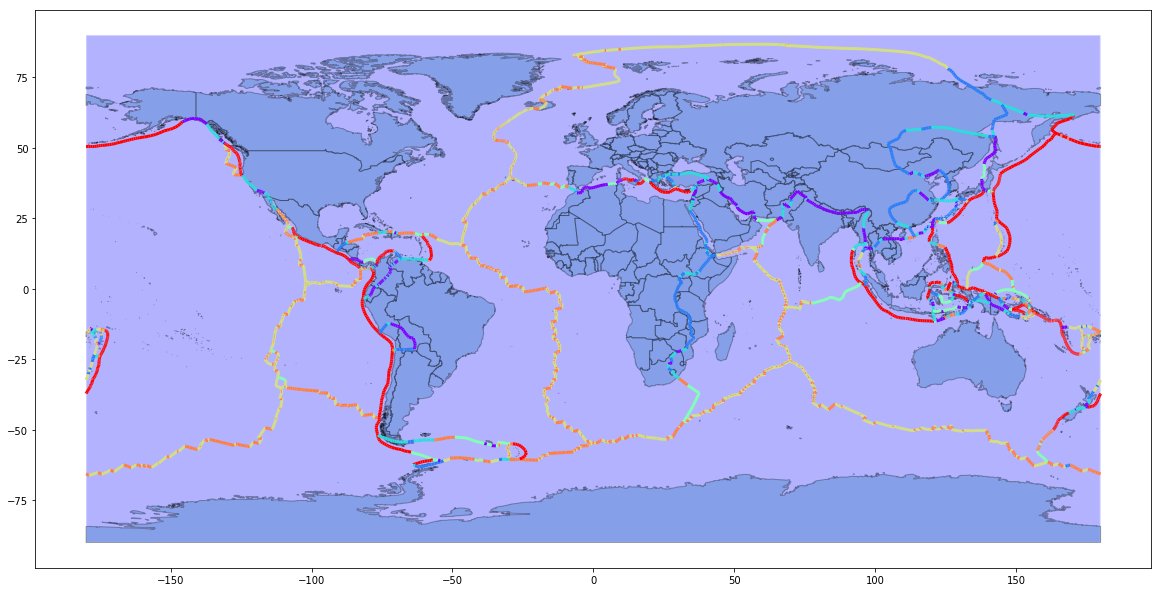

In [18]:
#earthquakes2_gdf
#volcanoes2_gdf
fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.3)
#earthquakes2_gdf.plot(ax=ax, markersize = 5, color = "red")
#eruptions_new_gdf.plot(ax=ax, markersize = 5, color = "orange")
#eruptions_gdf.plot(ax=ax, markersize = 5, color = "green")
#tsunamis_gdf.plot(ax=ax, markersize = 5, color = "yellow")
boundaries_gdf.plot(ax=ax, column = "STEPCLASS", cmap = "rainbow", lw = 3)
#vents_gdf.plot(ax=ax, markersize = 5, color = "blue")
#eruptions_more_gdf.plot(ax=ax, markersize = 5, color = "yellow")